In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import cv2
from os.path import join, exists, isdir
from pathlib import Path
import random
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.util import random_noise
import skimage.io

In [11]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

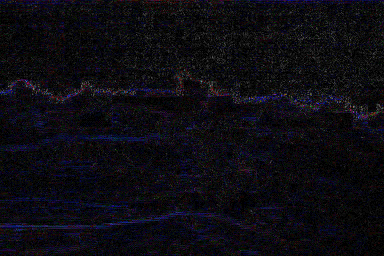

In [12]:
path='/kaggle/input/casiav2revised/CASIA2.0_revised/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
quality=91
convert_to_ela_image(path, quality)

In [13]:
def compute_ela_cv(path, quality):
    temp_filename = '/kaggle/working/temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [5]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

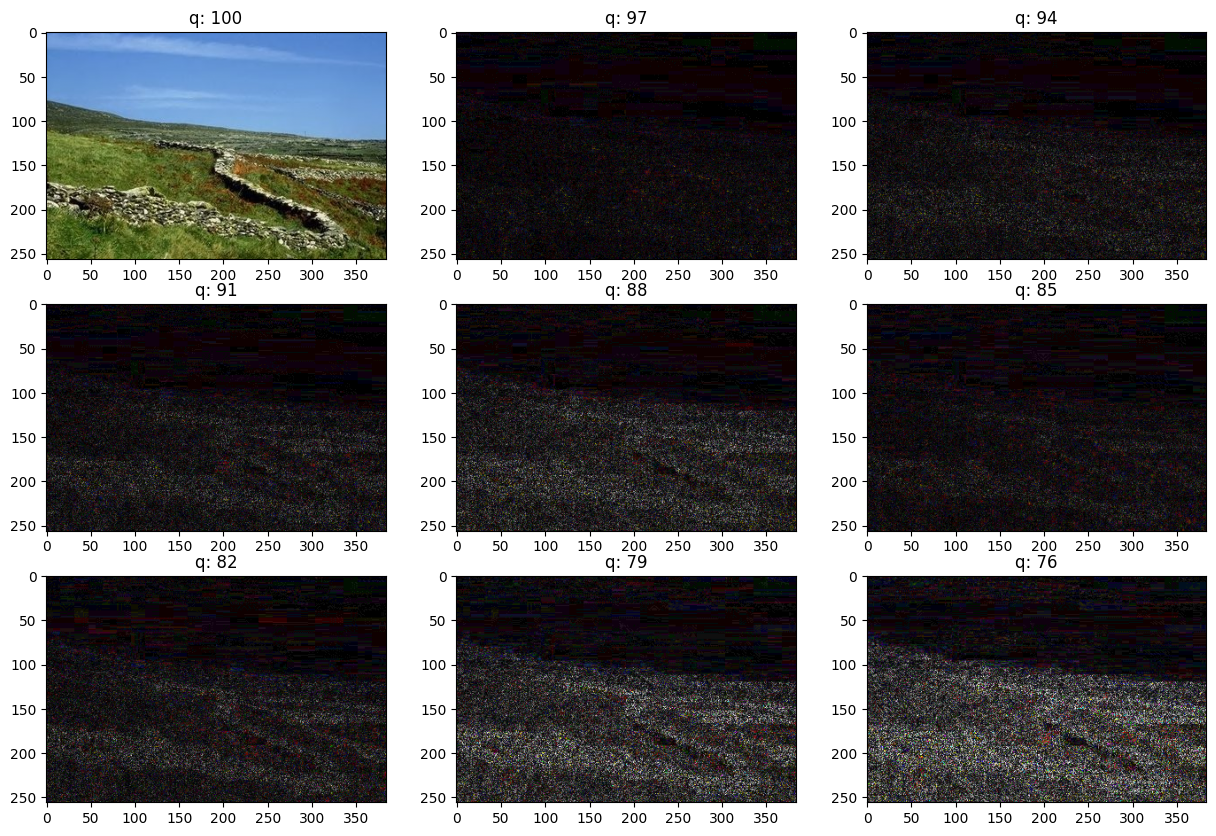

In [6]:
CASIA2 = "/kaggle/input/casiav2revised/CASIA2.0_revised"
p = join(CASIA2, 'Au/')

p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

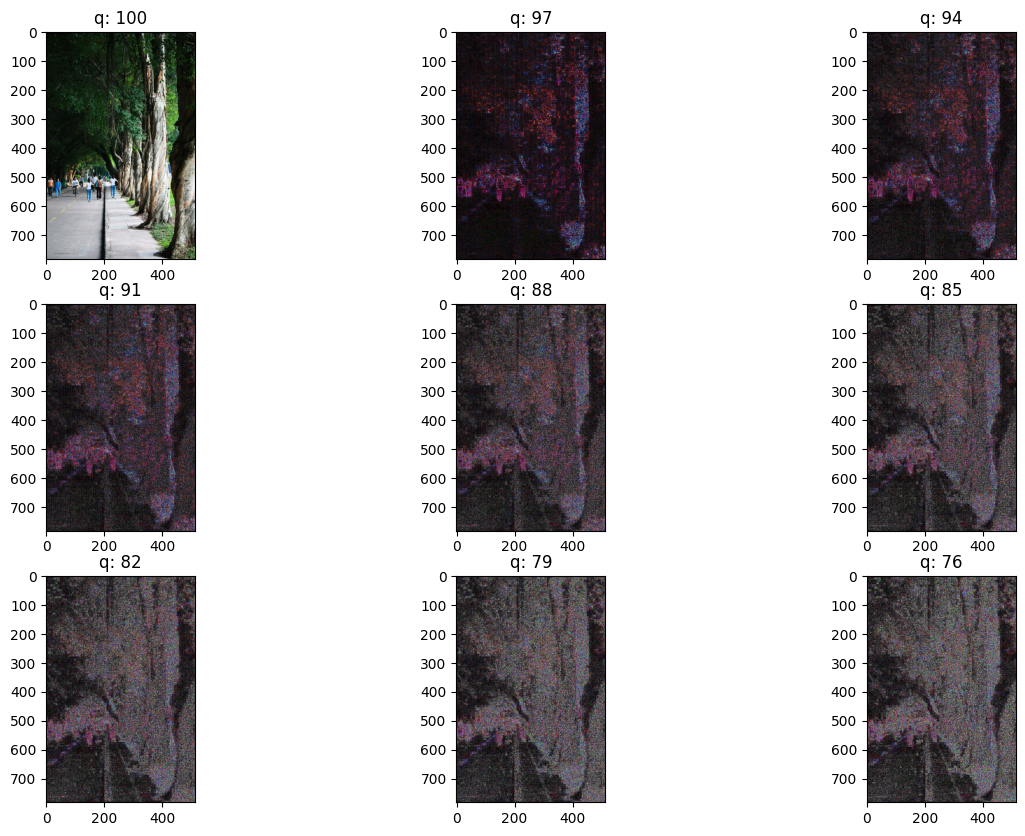

In [7]:
p = join(CASIA2, 'Tp/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [14]:
image_size=(128,128)

In [15]:
def prepare_image(image_path):
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    
    # Resize the ELA image
    resized_ela_image = ela_image.resize(image_size)
    
    # Convert the resized ELA image to a NumPy array and normalize
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    # Add noise residuals using the SRM technique
    srm_residuals = compute_srm_residuals(image)
    image_with_srm = image + srm_residuals
    
    return image_with_srm

def compute_srm_residuals(image):
    # Compute the noise residuals using the SRM technique
    sigma_estimation = estimate_sigma(image,average_sigmas=True)
    srm_residuals = denoise_wavelet(image, sigma=sigma_estimation, wavelet='haar', method='BayesShrink', mode='soft')
    
    return srm_residuals

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real
import random
path = '/kaggle/input/casiav2revised/CASIA2.0_revised/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:12000]
Y = Y[:12000]
print(len(X), len(Y))

/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
7491 7491


In [11]:
path = '/kaggle/input/casiav2revised/CASIA2.0_revised/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
Processing 12500 images
12614 12614


/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


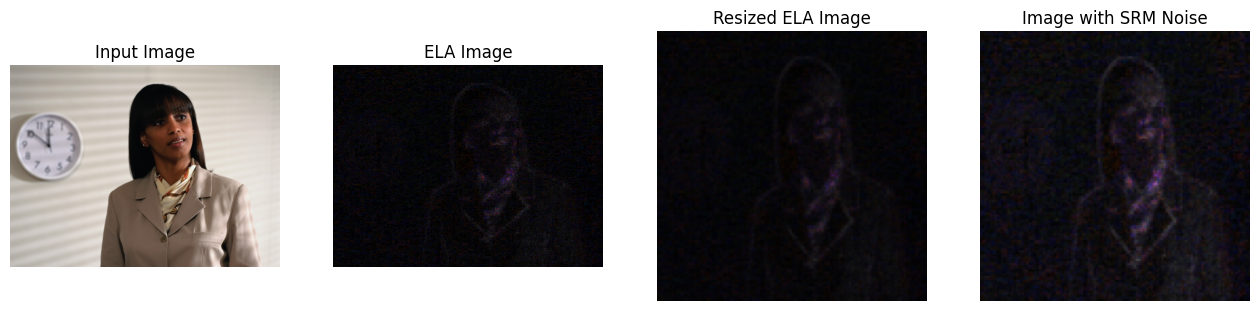

In [12]:
def prepare_image(image_path):
    # Load the original image
    original_image = Image.open(image_path)
    
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    
    # Resize the ELA image
    resized_ela_image = ela_image.resize(image_size)
    
    # Convert the resized ELA image to a NumPy array and normalize
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    # Add noise residuals using the SRM technique
    srm_residuals = compute_srm_residuals(image)
    image_with_srm = image + srm_residuals
    
    return original_image, image_with_srm

# Example usage
image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Au/Au_cha_20001.jpg"
original_image, image_with_srm = prepare_image(image_path)

# Display the original, ELA, and processed images
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(convert_to_ela_image(image_path, 91))
plt.title("ELA Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(convert_to_ela_image(image_path, 91).resize(image_size))
plt.title("Resized ELA Image")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_with_srm)
plt.title("Image with SRM Noise")
plt.axis('off')

plt.show()

/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


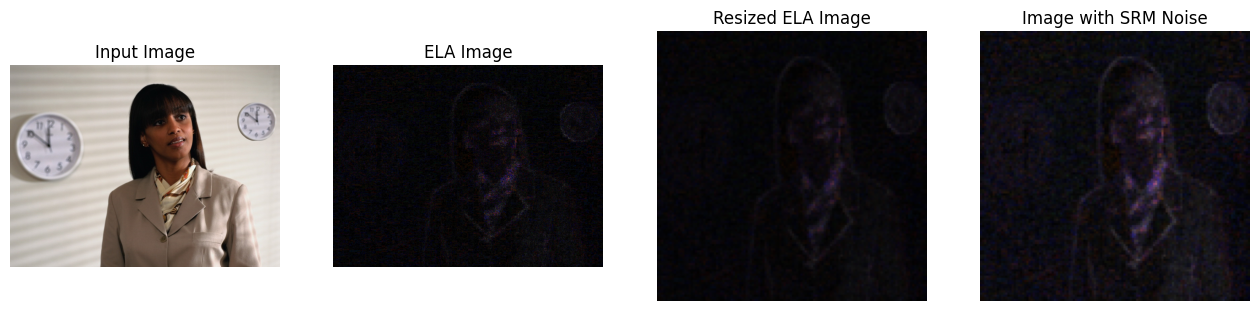

In [13]:
def prepare_image(image_path):
    # Load the original image
    original_image = Image.open(image_path)
    
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    
    # Resize the ELA image
    resized_ela_image = ela_image.resize(image_size)
    
    # Convert the resized ELA image to a NumPy array and normalize
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    # Add noise residuals using the SRM technique
    srm_residuals = compute_srm_residuals(image)
    image_with_srm = image + srm_residuals
    
    return original_image, image_with_srm

# Example usage
image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Tp/Tp_S_NRN_S_B_cha20001_cha20001_01504.tif"
original_image, image_with_srm = prepare_image(image_path)

# Display the original, ELA, and processed images
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(convert_to_ela_image(image_path, 91))
plt.title("ELA Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(convert_to_ela_image(image_path, 91).resize(image_size))
plt.title("Resized ELA Image")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_with_srm)
plt.title("Image with SRM Noise")
plt.axis('off')
plt.show()

In [14]:
import numpy as np
from sklearn.decomposition import PCA

# Convert X from a list to a NumPy array
X = np.array(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=100)  # Set the number of components to keep
X_pca = pca.fit_transform(X.reshape(X.shape[0], -1))

# Convert Y to categorical
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

10091 10091
2523 2523


In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten the image arrays
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)

# Create and train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_flattened, np.argmax(Y_train, axis=1))

# Make predictions on the validation set
Y_pred = nb_classifier.predict(X_val_flattened)

# Calculate metrics
accuracy_nb = accuracy_score(np.argmax(Y_val, axis=1), Y_pred)
precision_nb = precision_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
recall_nb = recall_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
f1_nb = f1_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')

print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1 Score:", f1_nb)

Accuracy: 0.7931034482758621
Precision: 0.7878472576614992
Recall: 0.803882019594671
F1 Score: 0.7887791393647172


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten the image arrays
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)

# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_flattened, np.argmax(Y_train, axis=1))

# Make predictions on the validation set
Y_pred = knn_classifier.predict(X_val_flattened)

# Calculate metrics
accuracy_knn = accuracy_score(np.argmax(Y_val, axis=1), Y_pred)
precision_knn = precision_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
recall_knn = recall_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
f1_knn = f1_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')

print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_knn)

Accuracy: 0.539833531510107
Precision: 0.6223997376311844
Recall: 0.6007835207885758
F1 Score: 0.5333230307206385


In [18]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_train_svm = np.argmax(Y_train, axis=1)
Y_val_svm = np.argmax(Y_val, axis=1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Create and train the SVM model
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_flat, Y_train_svm)

# Make predictions on the validation set
Y_pred = svm.predict(X_val_flat)

# Calculate metrics
accuracy_svm = accuracy_score(Y_val_svm, Y_pred)
precision_svm = precision_score(Y_val_svm, Y_pred, average='macro')
recall_svm = recall_score(Y_val_svm, Y_pred, average='macro')
f1_svm = f1_score(Y_val_svm, Y_pred, average='macro')

print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)

Accuracy: 0.8042013476020611
Precision: 0.7945258357113738
Recall: 0.8075432166920524
F1 Score: 0.7979728590694539


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten the image arrays
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)

# Create and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=0)
dt_classifier.fit(X_train_flattened, np.argmax(Y_train, axis=1))

# Make predictions on the validation set
Y_pred = dt_classifier.predict(X_val_flattened)

# Calculate metrics
accuracy_dt = accuracy_score(np.argmax(Y_val, axis=1), Y_pred)
precision_dt = precision_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
recall_dt = recall_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
f1_dt = f1_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')

print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)

Accuracy: 0.7423701942132382
Precision: 0.7285269253672351
Recall: 0.7338137774614724
F1 Score: 0.7306169716482145


In [20]:
from tabulate import tabulate

# Example metrics for each model (replace with actual values)
ml_models = ["\033[1mSVM\033[0m", "\033[1mNaive Bayes\033[0m", "\033[1mDecision Tree\033[0m", "\033[1mKNN\033[0m"]
ml_accuracy = [accuracy_svm, accuracy_nb, accuracy_dt, accuracy_knn]
ml_precision = [precision_svm, precision_nb, precision_dt, precision_knn]
ml_recall = [recall_svm, recall_nb, recall_dt, recall_knn]
ml_f1 = [f1_svm, f1_nb, f1_dt, f1_knn]

ml_data = zip(ml_models, ml_accuracy, ml_precision, ml_recall, ml_f1)

headers = ["\033[1mModel\033[0m", "\033[1mAccuracy\033[0m", "\033[1mPrecision\033[0m", "\033[1mRecall\033[0m", "\033[1mF1 Score\033[0m"]

ml_table = tabulate(ml_data, headers=headers, tablefmt="grid", showindex=False, numalign="center", stralign="center")

# Print with bold headings
print("\n\033[1mMachine Learning Models:\033[0m")
print(ml_table)


Machine Learning Models:
+---------------+------------+-------------+----------+------------+
|     Model     |  Accuracy  |  Precision  |  Recall  |  F1 Score  |
+===============+============+=============+==========+============+
|      SVM      |  0.804201  |  0.794526   | 0.807543 |  0.797973  |
+---------------+------------+-------------+----------+------------+
|  Naive Bayes  |  0.793103  |  0.787847   | 0.803882 |  0.788779  |
+---------------+------------+-------------+----------+------------+
| Decision Tree |  0.74237   |  0.728527   | 0.733814 |  0.730617  |
+---------------+------------+-------------+----------+------------+
|      KNN      |  0.539834  |   0.6224    | 0.600784 |  0.533323  |
+---------------+------------+-------------+----------+------------+


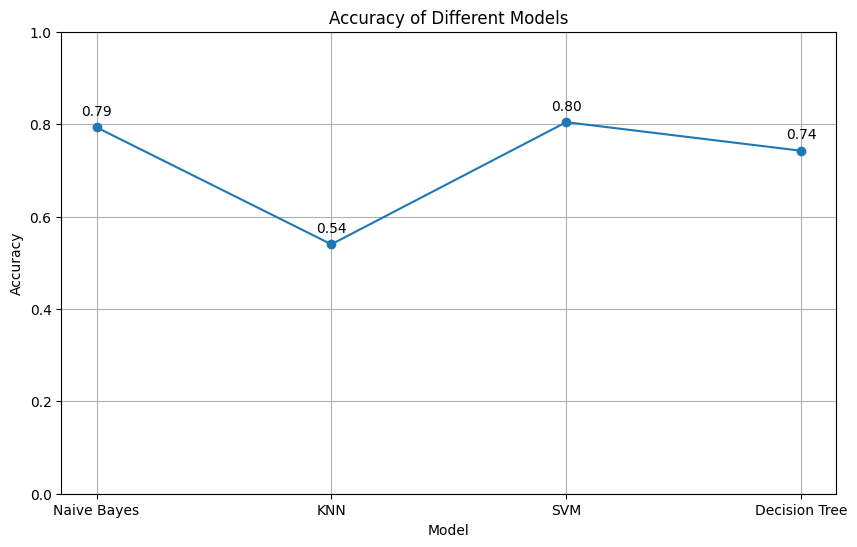

In [21]:
import matplotlib.pyplot as plt

# Data for the models' accuracy
models = ['Naive Bayes', 'KNN', 'SVM', 'Decision Tree']
accuracies = [accuracy_nb, accuracy_knn, accuracy_svm, accuracy_dt]

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o')
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

# Adding accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')

plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Flatten the training and validation data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier
rf_classifier.fit(X_train_flat, np.argmax(Y_train, axis=1))

# Make predictions on the validation set
Y_pred = rf_classifier.predict(X_val_flat)

# Calculate metrics
accuracy_rf = accuracy_score(np.argmax(Y_val, axis=1), Y_pred)
precision_rf = precision_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
recall_rf = recall_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
f1_rf = f1_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')

# Print the metrics
print("Random Forest Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Metrics:
Accuracy: 0.8533491874752279
Precision: 0.8450888192267503
Recall: 0.8439852474608738
F1 Score: 0.8445271477507559


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have X_train, X_val, Y_train, Y_val already defined

# Initialize the AdaBoost classifier with 50 weak learners
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=0)

# Flatten the training and validation data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train_flat, np.argmax(Y_train, axis=1))

# Make predictions on the validation set
Y_pred = adaboost_classifier.predict(X_val_flat)

# Calculate metrics
accuracy_adaboost = accuracy_score(np.argmax(Y_val, axis=1), Y_pred)
precision_adaboost = precision_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
recall_adaboost = recall_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')
f1_adaboost = f1_score(np.argmax(Y_val, axis=1), Y_pred, average='macro')

# Print the metrics
print("AdaBoost Metrics:")
print("Accuracy:", accuracy_adaboost)
print("Precision:", precision_adaboost)
print("Recall:", recall_adaboost)
print("F1 Score:", f1_adaboost)

AdaBoost Metrics:
Accuracy: 0.807372175980975
Precision: 0.7967386218698526
Recall: 0.8079412958023772
F1 Score: 0.80035527044189


In [25]:
from tabulate import tabulate

# Example metrics for each model (replace with actual values)
en_models = ["\033[1mRandom Forest\033[0m", "\033[1mAda Boost\033[0m"]
en_accuracy = [accuracy_rf, accuracy_adaboost]
en_precision = [precision_rf, precision_adaboost]
en_recall = [recall_rf, recall_adaboost]
en_f1 = [f1_rf, f1_adaboost]

en_data = zip(en_models, en_accuracy, en_precision, en_recall, en_f1)

headers = ["\033[1mModel\033[0m", "\033[1mAccuracy\033[0m", "\033[1mPrecision\033[0m", "\033[1mRecall\033[0m", "\033[1mF1 Score\033[0m"]

en_table = tabulate(en_data, headers=headers, tablefmt="grid", showindex=False, numalign="center", stralign="center")

# Print with bold headings
print("\n\033[1mEnsemble Learning Models:\033[0m")
print(en_table)


Ensemble Learning Models:
+---------------+------------+-------------+----------+------------+
|     Model     |  Accuracy  |  Precision  |  Recall  |  F1 Score  |
+===============+============+=============+==========+============+
| Random Forest |  0.853349  |  0.845089   | 0.843985 |  0.844527  |
+---------------+------------+-------------+----------+------------+
|   Ada Boost   |  0.807372  |  0.796739   | 0.807941 |  0.800355  |
+---------------+------------+-------------+----------+------------+


In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the VGG16 model with pre-trained weights
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the top convolutional blocks
for layer in vgg_base.layers[:-4]:
    layer.trainable = False
# Add your own classification layers
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=vgg_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_16 = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32)

# Evaluate the model
loss_16, accuracy_16 = model.evaluate(X_val, Y_val)

# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_val_labels = np.argmax(Y_val, axis=1)

# Calculate precision, recall, and F1 score
precision_16 = precision_score(Y_val_labels, Y_pred_labels, average='weighted')
recall_16 = recall_score(Y_val_labels, Y_pred_labels, average='weighted')
f1_16 = f1_score(Y_val_labels, Y_pred_labels, average='weighted')

print("Validation Loss:", loss_16)
print("Validation Accuracy:", accuracy_16)
print("Precision:", precision_16)
print("Recall:", recall_16)
print("F1 Score:", f1_16)
model.save("VGG16.h5")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 9,177,346 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/50


2024-05-06 16:42:44.048560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-05-06 16:42:44.048629: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-05-06 16:42:44.048639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-05-06 16:42:44.048647: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-05-06 16:42:44.048655: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-05-06 16:42:44.048663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-05-06 16:42:44.048670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-05-06 16:42:44.048679: E external/local_xla/xla/ser

  5/316 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6803 - loss: 0.6727 

I0000 00:00:1715013771.787545     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8275 - loss: 0.3872

2024-05-06 16:43:01.561674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.00794, expected 2.39882
2024-05-06 16:43:01.561743: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.76034, expected 4.15122
2024-05-06 16:43:01.561768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.63933, expected 4.03021
2024-05-06 16:43:01.561781: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.08604, expected 3.47692
2024-05-06 16:43:01.561811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.80353, expected 3.19441
2024-05-06 16:43:01.561823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.49817, expected 2.88905
2024-05-06 16:43:01.561833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.10099, expected 2.49187
2024-05-06 16:43:01.561844: E external/local_xla/xla/se

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8276 - loss: 0.3871

W0000 00:00:1715013785.356665     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-06 16:43:09.483859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.86797, expected 2.42041
2024-05-06 16:43:09.483917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49159: 3.22272, expected 2.77516
2024-05-06 16:43:09.483926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49183: 3.19824, expected 2.75068
2024-05-06 16:43:09.483934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49195: 3.35146, expected 2.9039
2024-05-06 16:43:09.483941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49196: 2.97994, expected 2.53238
2024-05-06 16:43:09.483949: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49205: 3.01476, expected 2.5672
2024-05-06 16:43:09.483957: E external/loca

316/316 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.8276 - loss: 0.3870 - val_accuracy: 0.8668 - val_loss: 0.3162
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8661 - loss: 0.3180 - val_accuracy: 0.8078 - val_loss: 0.4128
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8818 - loss: 0.2919 - val_accuracy: 0.8740 - val_loss: 0.2912
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8971 - loss: 0.2440 - val_accuracy: 0.8807 - val_loss: 0.2813
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9076 - loss: 0.2185 - val_accuracy: 0.8720 - val_loss: 0.2912
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9171 - loss: 0.1871 - val_accuracy: 0.8815 - val_loss: 0.3008
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9257 - loss: 0.1668 - val_accuracy: 0.8799 - val_loss: 0.3141
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9320 - loss: 0.1520 - val_accurac

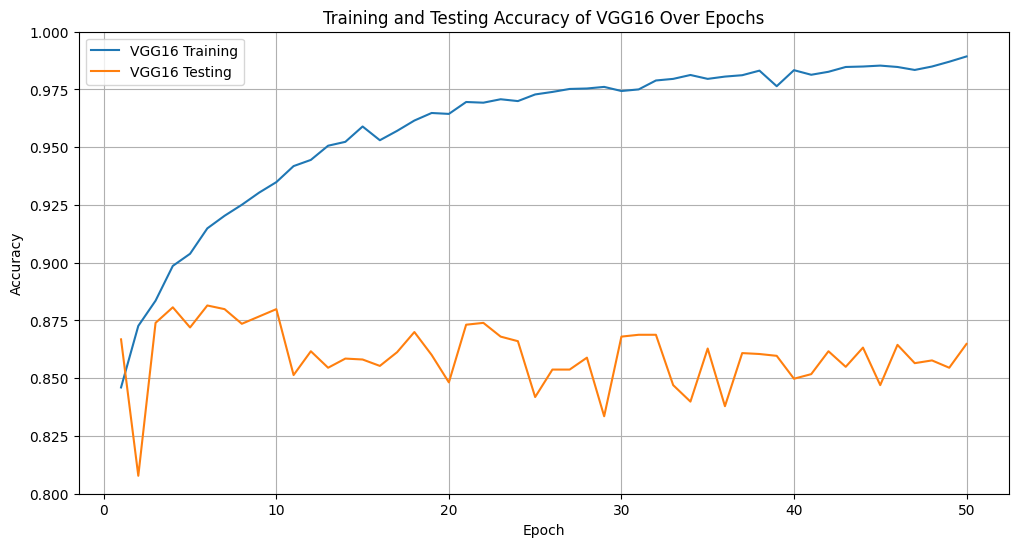

In [29]:
import matplotlib.pyplot as plt

# Data for VGG16 accuracy over epochs
epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
train_acc_16 = history_16.history['accuracy']
test_acc_16 = history_16.history['val_accuracy']

# Plotting the line graph for VGG16
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_16, label='VGG16 Training')
plt.plot(epochs, test_acc_16, label='VGG16 Testing')
plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
plt.title('Training and Testing Accuracy of VGG16 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.grid(True)
plt.show()


In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the MobileNetV2 model with pre-trained weights
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the top convolutional blocks
for layer in mobilenet_base.layers[:-4]:
    layer.trainable = False

# Add your own classification layers
x = Flatten()(mobilenet_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_mob = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32)

# Evaluate the model
loss_mob, accuracy_mob = model.evaluate(X_val, Y_val)

# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_val_labels = np.argmax(Y_val, axis=1)

# Calculate precision, recall, and F1 score
precision_mob = precision_score(Y_val_labels, Y_pred_labels, average='weighted')
recall_mob = recall_score(Y_val_labels, Y_pred_labels, average='weighted')
f1_mob = f1_score(Y_val_labels, Y_pred_labels, average='weighted')

print("Validation Loss:", loss_mob)
print("Validation Accuracy:", accuracy_mob)
print("Precision:", precision_mob)
print("Recall:", recall_mob)
print("F1 Score:", f1_mob)
model.save("mobilenetv2.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 7,501,634 (28.62 MB)

 Trainable params: 5,656,450 (21.58 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.8241 - loss: 0.4211 - val_accuracy: 0.8648 - val_loss: 0.3162
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9169 - loss: 0.2049 - val_accuracy: 0.8700 - val_loss: 0.3129
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9454 - loss: 0.1331 - val_accuracy: 0.8664 - val_loss: 0.3129
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9567 - loss: 0.1054 - val_accuracy: 0.8664 - val_loss: 0.3798
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9711 - loss: 0.0787 - val_accuracy: 0.8676 - val_loss: 0.3583
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9764 - loss: 0.0651 - val_accuracy: 0.8652 - val_loss: 0.3961
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9801 - loss: 0.0538 - val_accuracy: 0.8672 - val_loss: 0.4235
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9841 - loss: 0.0447 - val_acc

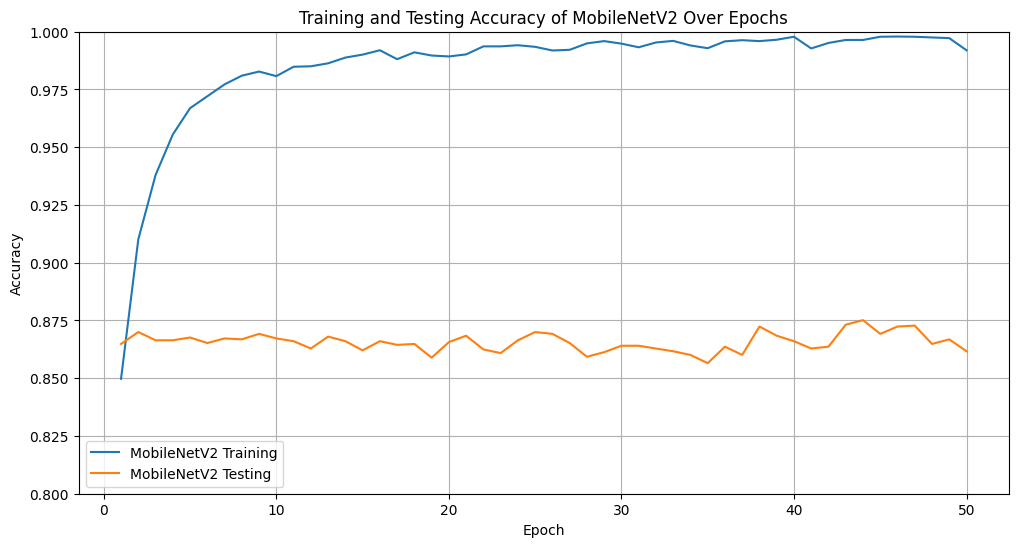

In [32]:
import matplotlib.pyplot as plt

# Data for MobileNetV2 accuracy over epochs
epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
train_acc_mob = history_mob.history['accuracy']
test_acc_mob = history_mob.history['val_accuracy']

# Plotting the line graph for MobileNetV2
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_mob, label='MobileNetV2 Training')
plt.plot(epochs, test_acc_mob, label='MobileNetV2 Testing')
plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
plt.title('Training and Testing Accuracy of MobileNetV2 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()


In [33]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the VGG19 model with pre-trained weights
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the top convolutional blocks
for layer in vgg19_base.layers[:-4]:
    layer.trainable = False

# Add your own classification layers
x = Flatten()(vgg19_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=vgg19_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_19 = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32)

# Evaluate the model
loss_19, accuracy_19 = model.evaluate(X_val, Y_val)

# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_val_labels = np.argmax(Y_val, axis=1)

# Calculate precision, recall, and F1 score
precision_19 = precision_score(Y_val_labels, Y_pred_labels, average='weighted')
recall_19 = recall_score(Y_val_labels, Y_pred_labels, average='weighted')
f1_19 = f1_score(Y_val_labels, Y_pred_labels, average='weighted')

print("Validation Loss:", loss_19)
print("Validation Accuracy:", accuracy_19)
print("Precision:", precision_19)
print("Recall:", recall_19)
print("F1 Score:", f1_19)
model.save("VGG19.h5")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           51

 Total params: 22,122,306 (84.39 MB)

 Trainable params: 9,177,346 (35.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7870 - loss: 0.4382

W0000 00:00:1715014670.772105     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7871 - loss: 0.4380 - val_accuracy: 0.8434 - val_loss: 0.3594
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.8516 - loss: 0.3432 - val_accuracy: 0.8518 - val_loss: 0.3567
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8598 - loss: 0.3273 - val_accuracy: 0.8494 - val_loss: 0.3717
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8734 - loss: 0.2986 - val_accuracy: 0.8545 - val_loss: 0.3332
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8598 - loss: 0.3162 - val_accuracy: 0.8339 - val_loss: 0.3768
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8745 - loss: 0.2883 - val_accuracy: 0.8335 - val_loss: 0.4081
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8835 - loss: 0.2782 - val_accuracy: 0.8145 - val_loss: 0.4126
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8628 - loss: 0.3035 - val_accurac

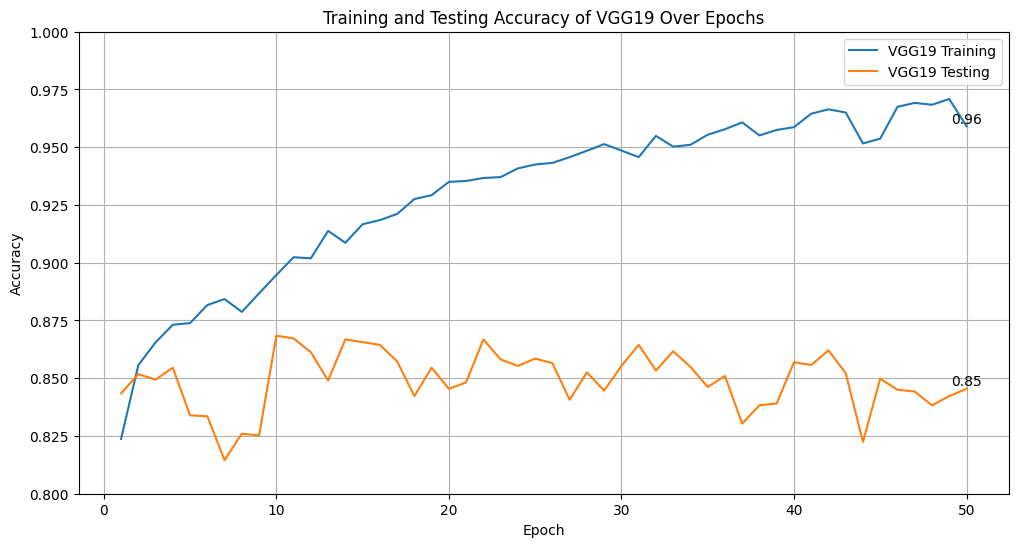

In [34]:
import matplotlib.pyplot as plt

# Data for VGG19 accuracy over epochs
epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
train_acc_19 = history_19.history['accuracy']
test_acc_19 = history_19.history['val_accuracy']

# Plotting the line graph for VGG19
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_19, label='VGG19 Training')
plt.plot(epochs, test_acc_19, label='VGG19 Testing')
plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
plt.title('Training and Testing Accuracy of VGG19 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.text(50, train_acc_19[49], f'{train_acc_19[49]:.2f}', ha='center', va='bottom')
plt.text(50, test_acc_19[49], f'{test_acc_19[49]:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()

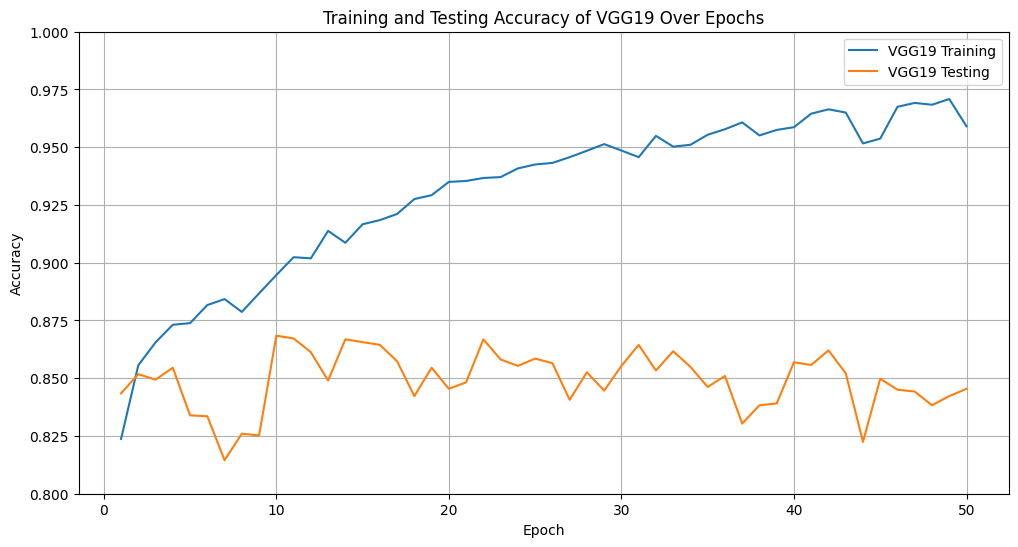

In [35]:
import matplotlib.pyplot as plt

# Data for VGG19 accuracy over epochs
epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
train_acc_19 = history_19.history['accuracy']
test_acc_19 = history_19.history['val_accuracy']

# Plotting the line graph for VGG19
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_19, label='VGG19 Training')
plt.plot(epochs, test_acc_19, label='VGG19 Testing')
plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
plt.title('Training and Testing Accuracy of VGG19 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()


In [36]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the DenseNet121 model with pre-trained weights
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the top convolutional blocks
for layer in densenet_base.layers[:-4]:
    layer.trainable = True

# Add your own classification layers
x = Flatten()(densenet_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=densenet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_dense = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32)

# Evaluate the model
loss_dense, accuracy_dense = model.evaluate(X_val, Y_val)

# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_val_labels = np.argmax(Y_val, axis=1)

# Calculate precision, recall, and F1 score
precision_dense = precision_score(Y_val_labels, Y_pred_labels, average='weighted')
recall_dense = recall_score(Y_val_labels, Y_pred_labels, average='weighted')
f1_dense = f1_score(Y_val_labels, Y_pred_labels, average='weighted')

print("Validation Loss:", loss_dense)
print("Validation Accuracy:", accuracy_dense)
print("Precision:", precision_dense)
print("Recall:", recall_dense)
print("F1 Score:", f1_dense)
model.save("densenet121.h5")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 11,232,578 (42.85 MB)

 Trainable params: 11,148,930 (42.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 263s 387ms/step - accuracy: 0.8217 - loss: 0.4045 - val_accuracy: 0.4895 - val_loss: 1.0035
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9282 - loss: 0.1602 - val_accuracy: 0.8989 - val_loss: 0.2018
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9532 - loss: 0.1062 - val_accuracy: 0.8910 - val_loss: 0.2352
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9566 - loss: 0.1062 - val_accuracy: 0.9116 - val_loss: 0.2195
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.9646 - loss: 0.0827 - val_accuracy: 0.9025 - val_loss: 0.2337
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9732 - loss: 0.0645 - val_accuracy: 0.9045 - val_loss: 0.2368
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9708 - loss: 0.0733 - val_accuracy: 0.9136 - val_loss: 0.3280
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9746 - loss: 0.0593 

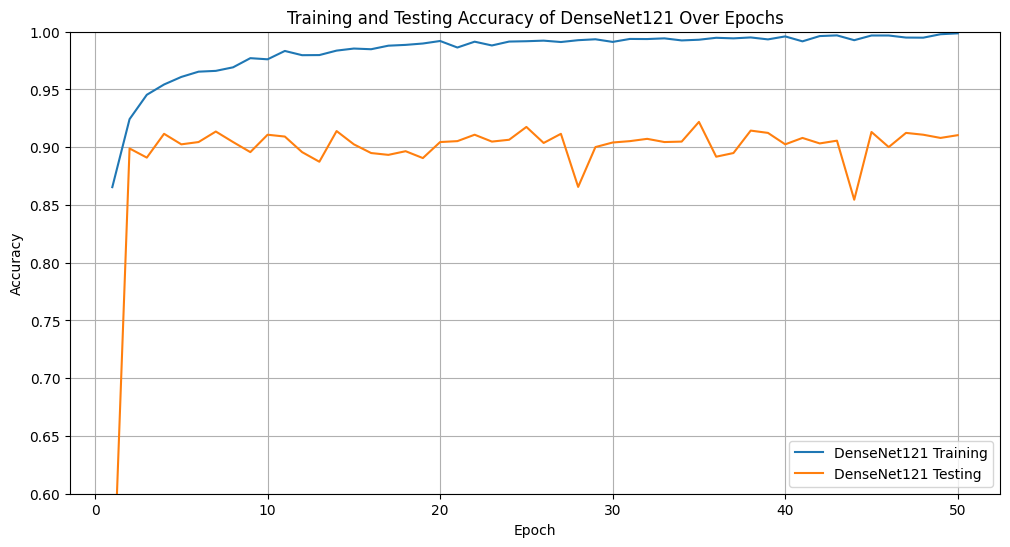

In [38]:
import matplotlib.pyplot as plt

# Data for DenseNet121 accuracy over epochs
epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
train_acc_dense = history_dense.history['accuracy']
test_acc_dense = history_dense.history['val_accuracy']

# Plotting the line graph for DenseNet121
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_dense, label='DenseNet121 Training')
plt.plot(epochs, test_acc_dense, label='DenseNet121 Testing')
plt.ylim(0.60, 1.0)  # Set the y-axis limits from 0.80 to 1.0
plt.title('Training and Testing Accuracy of DenseNet121 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [39]:
from tabulate import tabulate

# Example metrics for each model (replace with actual values)
tl_models = ["\033[1mVGG16\033[0m", "\033[1mMobileNetV2\033[0m", "\033[1mVGG19\033[0m", "\033[1mDenseNet121\033[0m"]

tl_accuracy = [accuracy_16, accuracy_mob, accuracy_19, accuracy_dense]

tl_precision = [precision_16, precision_mob, precision_19, precision_dense]
tl_recall = [recall_16, recall_mob, recall_19, recall_dense]

tl_f1 = [f1_16, f1_mob, f1_19, f1_dense]

tl_data = zip(tl_models, tl_accuracy, tl_precision, tl_recall, tl_f1)

headers = ["\033[1mModel\033[0m", "\033[1mAccuracy\033[0m", "\033[1mPrecision\033[0m", "\033[1mRecall\033[0m", "\033[1mF1 Score\033[0m"]

tl_table = tabulate(tl_data, headers=headers, tablefmt="grid", showindex=False, numalign="center", stralign="center")

print("\n\033[1mPre Trained Models:\033[0m")
print(tl_table)


Pre Trained Models:
+-------------+------------+-------------+----------+------------+
|    Model    |  Accuracy  |  Precision  |  Recall  |  F1 Score  |
+=============+============+=============+==========+============+
|    VGG16    |  0.864843  |  0.866232   | 0.864843 |  0.865325  |
+-------------+------------+-------------+----------+------------+
| MobileNetV2 |  0.861673  |  0.862737   | 0.861673 |  0.862071  |
+-------------+------------+-------------+----------+------------+
|    VGG19    |  0.845422  |  0.848485   | 0.845422 |  0.846328  |
+-------------+------------+-------------+----------+------------+
| DenseNet121 |  0.910424  |  0.912141   | 0.910424 |  0.910853  |
+-------------+------------+-------------+----------+------------+


In [40]:
from tabulate import tabulate

# Data for the table
data = [
    ['\033[1mGaussianNB\033[0m', accuracy_nb, precision_nb, recall_nb, f1_nb],
    ['\033[1mKNeighborsClassifier\033[0m', accuracy_knn, precision_knn, recall_knn, f1_knn],
    ['\033[1mSVM\033[0m', accuracy_svm, precision_svm, recall_svm, f1_svm],
    ['\033[1mDecisionTreeClassifier\033[0m', accuracy_dt, precision_dt, recall_dt, f1_dt],
    ['\033[1mRandomForestClassifier\033[0m', accuracy_rf, precision_rf, recall_rf, f1_rf],
    ['\033[1mAdaBoostClassifier\033[0m', accuracy_adaboost, precision_adaboost, recall_adaboost, f1_adaboost],
    ['\033[1mVGG16\033[0m', accuracy_16, precision_16, recall_16, f1_16],
    ['\033[1mMobileNetV2\033[0m', accuracy_mob, precision_mob, recall_mob, f1_mob],
    ['\033[1mVGG19\033[0m', accuracy_19, precision_19, recall_19, f1_19],
    ['\033[1mDenseNet121\033[0m', accuracy_dense, precision_dense, recall_dense, f1_dense]
]

headers = ['\033[1mModel\033[0m', '\033[1mAccuracy\033[0m', '\033[1mPrecision\033[0m', '\033[1mRecall\033[0m', '\033[1mF1 Score\033[0m']

# Creating the table
table = tabulate(data, headers=headers, tablefmt='grid')

print(table)


+------------------------+------------+-------------+----------+------------+
| Model                  |   Accuracy |   Precision |   Recall |   F1 Score |
+========================+============+=============+==========+============+
| GaussianNB             |   0.793103 |    0.787847 | 0.803882 |   0.788779 |
+------------------------+------------+-------------+----------+------------+
| KNeighborsClassifier   |   0.539834 |    0.6224   | 0.600784 |   0.533323 |
+------------------------+------------+-------------+----------+------------+
| SVM                    |   0.804201 |    0.794526 | 0.807543 |   0.797973 |
+------------------------+------------+-------------+----------+------------+
| DecisionTreeClassifier |   0.74237  |    0.728527 | 0.733814 |   0.730617 |
+------------------------+------------+-------------+----------+------------+
| RandomForestClassifier |   0.853349 |    0.845089 | 0.843985 |   0.844527 |
+------------------------+------------+-------------+----------+

/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[7.0556064e-07 9.9999928e-01]]


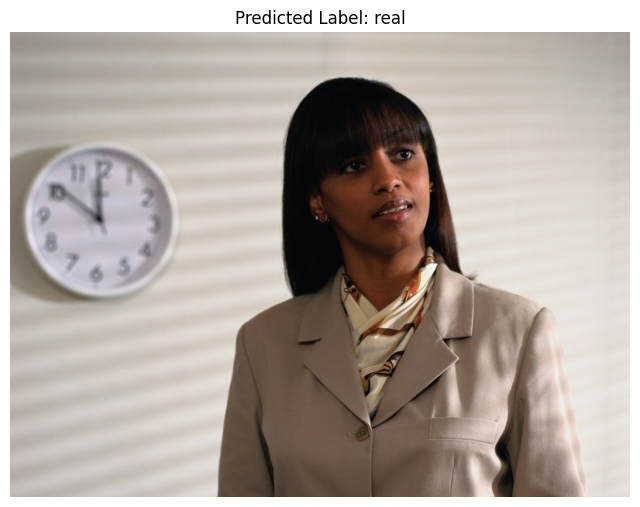

In [19]:
def prepare_image(image_path):
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    
    # Resize the ELA image
    resized_ela_image = ela_image.resize(image_size)
    
    # Convert the resized ELA image to a NumPy array and normalize
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    # Add noise residuals using the SRM technique
    srm_residuals = compute_srm_residuals(image)
    image_with_srm = image + srm_residuals
    
    return image_with_srm
from tensorflow.keras.models import load_model

best_model_path = "/kaggle/input/model-densenet121/densenet121.h5"
best_model = load_model(best_model_path)

new_image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Au/Au_cha_20001.jpg"
new_image = prepare_image(new_image_path)
new_image = new_image.reshape(1, 128, 128, 3)
prediction = best_model.predict(new_image)
print(prediction)
predicted_class = np.argmax(prediction)
class_labels = ["fake", "real"]
predicted_label = class_labels[predicted_class]

# Display the original image with predicted and actual labels
original_image = Image.open(new_image_path)
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

/tmp/ipykernel_34/1761475526.py:19: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_estimation = estimate_sigma(image,average_sigmas=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[9.9994457e-01 5.5396875e-05]]


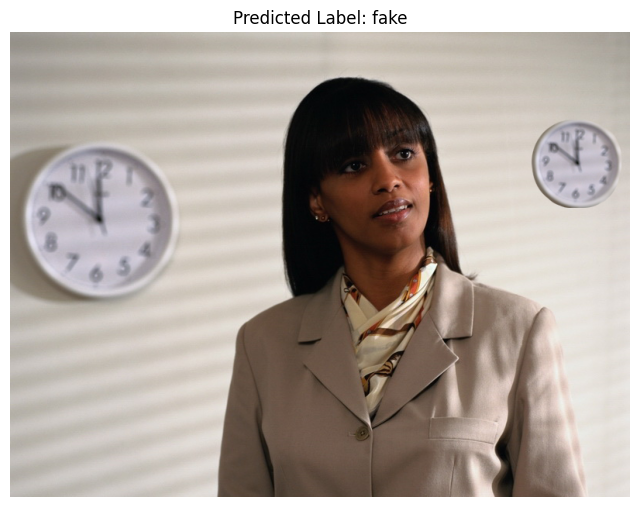

In [20]:
def prepare_image(image_path):
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    
    # Resize the ELA image
    resized_ela_image = ela_image.resize(image_size)
    
    # Convert the resized ELA image to a NumPy array and normalize
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    # Add noise residuals using the SRM technique
    srm_residuals = compute_srm_residuals(image)
    image_with_srm = image + srm_residuals
    
    return image_with_srm
from tensorflow.keras.models import load_model

best_model_path = "/kaggle/input/model-densenet121/densenet121.h5"
best_model = load_model(best_model_path)

new_image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Tp/Tp_S_NRN_S_B_cha20001_cha20001_01504.tif"
new_image = prepare_image(new_image_path)
new_image = new_image.reshape(1, 128, 128, 3)
prediction = best_model.predict(new_image)
print(prediction)
predicted_class = np.argmax(prediction)
class_labels = ["fake", "real"]
predicted_label = class_labels[predicted_class]

# Display the original image with predicted and actual labels
original_image = Image.open(new_image_path)
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()